In [64]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms 
from torch.utils import data
from torchsummary import summary

import os
import numpy as np
import random
import time
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 as cv

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [66]:
ROOT = './data'
BATCH= 64
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 10

In [67]:
dataset_full = datasets.FashionMNIST(root=ROOT, train=True, transform=None, download=True)
dataset_test = datasets.FashionMNIST(root=ROOT, train=True, transform=None, download=True)

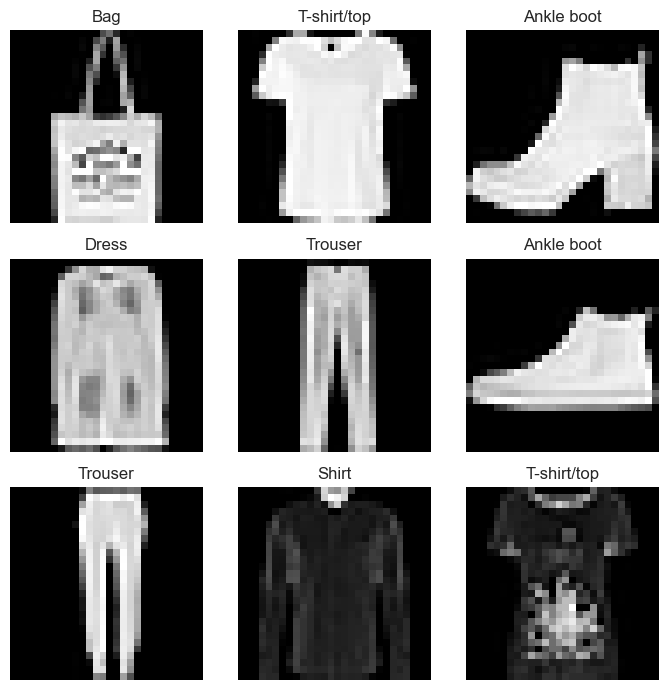

In [68]:
def preview(cols, rows):
    fig, axs = plt.subplots(cols, rows, figsize = (7, 7))
    axs = axs.flatten()

    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }


    for ax in axs:
        sample_idx = torch.randint(len(dataset_full), (1,)).item()
        img, label = dataset_full[sample_idx]
        ax.axis("off")
        ax.set_title(class_names[label],)
        ax.imshow(img, cmap = "grey")
    plt.tight_layout()
    plt.show()

cols, rows = 3, 3
preview(cols, rows)

In [69]:
VALID_RATIO = 0.8
n_train_examples = int(len(dataset_full) * VALID_RATIO)
n_val_examples = len(dataset_full) - n_train_examples


mean = dataset_full.data.float().mean() / 255
std  = dataset_full.data.float().std() / 255


# Define transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])


dataset_full_train = copy.deepcopy(dataset_full)
dataset_full_val = copy.deepcopy(dataset_full)


dataset_full_train.transform = train_transform
dataset_full_val.transform = test_transform
dataset_test.transform = test_transform

train_data_indice, val_data_indice = data.random_split(range(len(dataset_full)), 
                                         [n_train_examples, n_val_examples], 
                                         generator=torch.Generator().manual_seed(42))

train_data = data.Subset(dataset_full_train, train_data_indice)
val_data = data.Subset(dataset_full_val, val_data_indice)

train_dataloader = data.DataLoader(train_data, 
                                   batch_size=BATCH, 
                                   shuffle=True)

val_dataloader = data.DataLoader(val_data, 
                                 batch_size=BATCH, 
                                 shuffle=False)

test_dataloader = data.DataLoader(dataset_test, 
                                  batch_size=BATCH, 
                                  shuffle=False)

In [83]:
for X, y in train_dataloader:
    print(f"Shape of X [Batches, Channels, Height, Width]: {X.shape}")
    print(f"Shape of y: {len(y)} {y.dtype}")
    break

Shape of X [Batches, Channels, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: 64 torch.int64


In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, 2**9)
        self.linear2 = nn.Linear(2**9, 2**9)
        self.linear3 = nn.Linear(2**9, 2**8)
        self.linear4 = nn.Linear(2**8, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [71]:
model = NeuralNetwork(28*28, NUM_CLASSES).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
            Linear-3                  [-1, 512]         262,656
            Linear-4                  [-1, 256]         131,328
            Linear-5                   [-1, 10]           2,570
Total params: 798,474
Trainable params: 798,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.05
Estimated Total Size (MB): 3.06
----------------------------------------------------------------


In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
def train_and_val(model, train_dataloader, val_dataloader, criterion, optimizer, epochs, device, save_path = "./model"):
    train_accs = []
    train_losses = []
    val_accs = []
    val_losses = []
    best_evals = float('inf')

    for epoch in range(1, epochs+1):
        model.train()
        time_start = time.time()
        train_loss = 0.0
        acc = 0.0
        total_train = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            train_loss += loss.item()
            acc += (predicted == labels).sum().item() 

        train_accs.append(100*acc/total_train)
        train_losses.append(train_loss/len(train_dataloader))

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, labels).item()

                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_losses.append(val_loss/len(val_dataloader))
        val_accs.append(100*correct_val/total_val)

        print(f"Epoch {epoch}/{epochs}.. "
          f"Train loss: {train_losses[-1]:.3f}.. "
          f"Train accuracy: {train_accs[-1]:.3f}%.. "
          f"Val loss: {val_losses[-1]:.3f}.. "
          f"Val accuracy: {val_accs[-1]:.3f}%")
        
        if val_losses[-1] < best_evals:
            best_evals = val_losses[-1]
            torch.save(model.state_dict(), os.path.join(save_path, "best_fashion_model.pth"))
            print("Best model save")
        
        end_time = time.time()
        print(f"Epoch {epoch} completed in {end_time - time_start:.2f} seconds")

    return train_accs, train_losses, val_accs, val_losses

In [74]:
train_accs, train_losses, val_accs, val_losses = train_and_val(model, train_dataloader, val_dataloader, criterion, optimizer, epochs = 10, device = device)

Epoch 1/10.. Train loss: 0.487.. Train accuracy: 82.142%.. Val loss: 0.395.. Val accuracy: 85.300%
Best model save
Epoch 1 completed in 17.73 seconds
Epoch 2/10.. Train loss: 0.364.. Train accuracy: 86.588%.. Val loss: 0.345.. Val accuracy: 87.142%
Best model save
Epoch 2 completed in 11.50 seconds
Epoch 3/10.. Train loss: 0.324.. Train accuracy: 88.058%.. Val loss: 0.350.. Val accuracy: 86.883%
Epoch 3 completed in 11.37 seconds
Epoch 4/10.. Train loss: 0.298.. Train accuracy: 88.846%.. Val loss: 0.334.. Val accuracy: 88.067%
Best model save
Epoch 4 completed in 11.42 seconds
Epoch 5/10.. Train loss: 0.276.. Train accuracy: 89.619%.. Val loss: 0.315.. Val accuracy: 88.875%
Best model save
Epoch 5 completed in 11.41 seconds
Epoch 6/10.. Train loss: 0.259.. Train accuracy: 90.192%.. Val loss: 0.325.. Val accuracy: 88.817%
Epoch 6 completed in 34.85 seconds
Epoch 7/10.. Train loss: 0.241.. Train accuracy: 90.950%.. Val loss: 0.335.. Val accuracy: 88.583%
Epoch 7 completed in 23.35 second

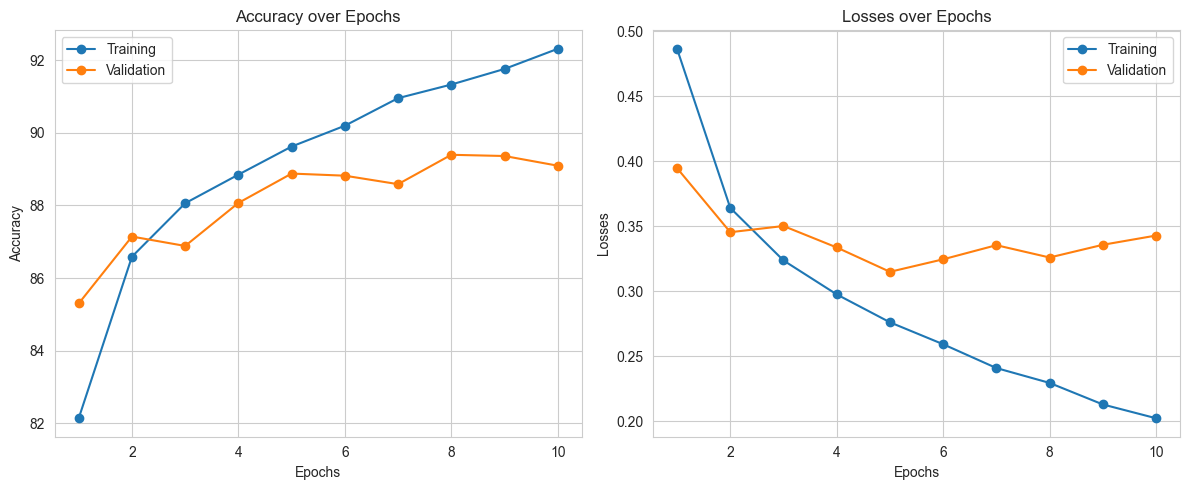

In [75]:
sns.set_style("whitegrid")
def plot_result(train_accs, train_losses, val_accs, val_losses):
    epochs = range(1, len(train_accs) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(epochs, train_accs, label = "Training", marker = 'o')
    axs[0].plot(epochs, val_accs, label = "Validation", marker = 'o')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(epochs, train_losses, label = "Training", marker = 'o')
    axs[1].plot(epochs, val_losses, label = "Validation", marker = 'o')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Losses")
    axs[1].set_title("Losses over Epochs")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_result(train_accs, train_losses, val_accs, val_losses)

In [76]:
def test(model, test_dataloader, criterion, device):
    model.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            test_loss += loss.item() * batch_size

            _, preds = torch.max(outputs, 1)
            total_test += batch_size
            correct_test += (preds == labels).sum().item()

    avg_loss = test_loss / total_test
    accuracy = 100.0 * correct_test / total_test

    return avg_loss, accuracy

val_losses, val_accs = test(model, test_dataloader, criterion, device)
print(val_losses, val_accs)

0.21901645653247834 92.15333333333334


In [77]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = dataset_test[0][0], dataset_test[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')



Predicted: "Ankle boot", Actual: "Ankle boot"


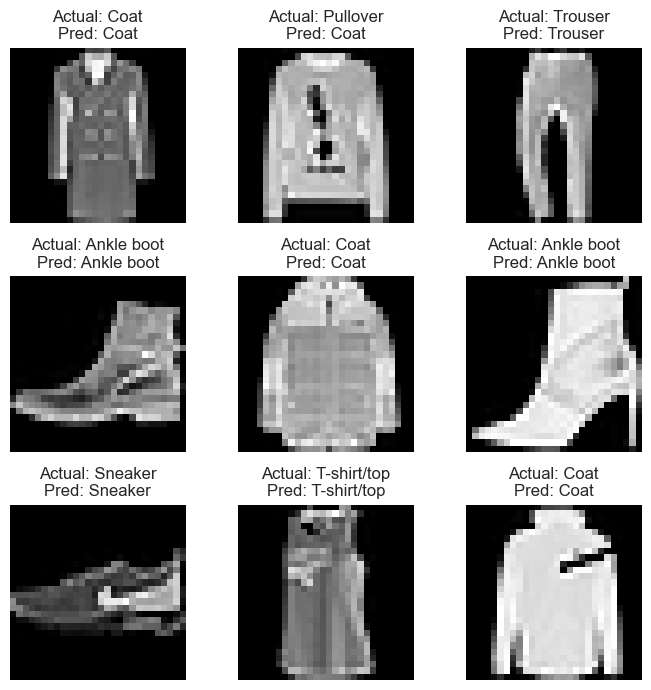

In [78]:
def preview(cols, rows, model, dataset_test, device):
    model.eval()

    fig, axs = plt.subplots(rows, cols, figsize=(7, 7))
    axs = axs.flatten()

    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    with torch.no_grad():
        for ax in axs:
            sample_idx = torch.randint(len(dataset_test), (1,)).item()
            img, label = dataset_test[sample_idx]

            img = img.to(device)
            logits = model(img.unsqueeze(0))
            pred_idx = logits.argmax(dim=1).item()

            predicted = class_names[pred_idx]
            actual = class_names[int(label)]

            ax.axis("off")
            ax.set_title(f"Actual: {actual}\nPred: {predicted}")

            ax.imshow(img.squeeze().cpu(), cmap="gray")

    plt.tight_layout()
    plt.show()
    
preview(cols, rows, model, dataset_test, device)